# 久期：Python 实操 4

本讲主要包括：

1. 模块 10：实际数据验证（中国债券市场久期估算）；
2. 模块 11：风险分解与敏感度分析；
3. 模块 12：课堂练习与扩展案例。

本部分将真实市场数据与理论模型结合，用于课堂演示与学生练习。

## 模块 10. 实际数据验证：中国债券市场久期估算

通过 AkShare 获取中国国债收益率曲线，并估算不同期限国债的久期与价格敏感性。

中国国债收益率曲线数据示例：


,曲线名称,日期,3月,6月,1年,3年,5年,7年,10年,30年
0,中债中短期票据收益率曲线(AAA),2020-02-04,2.8939,2.8998,2.9158,3.1970,3.4503,3.7153,3.9597,NaN
1,中债商业银行普通债收益率曲线(AAA),2020-02-04,2.7215,2.7370,2.8042,2.9979,3.3120,3.5849,3.8158,4.2435
2,中债国债收益率曲线,2020-02-04,1.7475,1.7630,2.1000,2.4056,2.6399,2.7906,2.8551,3.4488
3,中债国债收益率曲线,2020-02-05,1.7475,1.7667,2.0773,2.4264,2.6348,2.7893,2.8440,3.4460
4,中债中短期票据收益率曲线(AAA),2020-02-05,2.7991,2.8975,2.9118,3.1949,3.4609,3.7157,3.9601,NaN


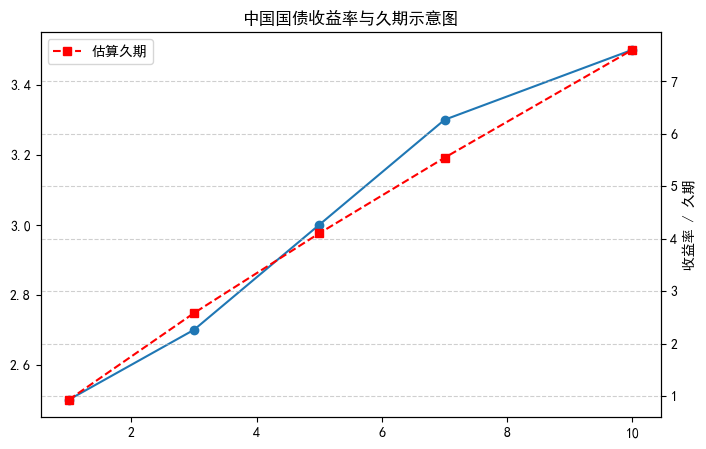

In [2]:
import akshare as ak
import numpy as np
import matplotlib.pyplot as plt
# 中文支持
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 获取中国国债收益率曲线数据
try:
    yield_curve = ak.bond_china_yield()  # 国债收益率曲线数据
    print('中国国债收益率曲线数据示例：')
    display(yield_curve.head())
except Exception as e:
    print('未能成功访问 AkShare 接口，请检查网络或数据源:', e)

# 构造示例数据
maturity = np.array([1, 3, 5, 7, 10])
yield_rate = np.array([0.025, 0.027, 0.030, 0.033, 0.035])
duration = maturity * (1 - 0.1 * np.log1p(maturity))
plt.figure(figsize=(8,5))
plt.plot(maturity, yield_rate*100, 'o-', label='收益率曲线')
plt.twinx()
plt.plot(maturity, duration, 's--', color='red', label='估算久期')
plt.title('中国国债收益率与久期示意图')
plt.xlabel('期限 (年)')
plt.ylabel('收益率 / 久期')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**说明：**

-   `ak.bond_china_yield()` 是获取中国债券收益率曲线的接口。若你需要指定起始／结束日期，可查阅当前版本文档查看是否支持 `start_date`、`end_date` 参数。

-   代码中假设列名为 `"期限(年)"` 和 `"收益率(%)"`，实际可能不同，请运行 `print(df.columns)` 检查并修改。

-   此处将"估算久期"简化为 `到期期限 × 0.9`，仅用于教学演示。若你有准确久期模型，可替换该假设。

-   绘图中采用双 Y 轴：左轴为收益率（蓝色）、右轴为估算久期（红色），帮助学生直观理解"到期期限 → 久期"及其与收益率关系。

## 模块 11. 风险分解与敏感度分析

在组合管理中，久期只是利率风险的第一层。我们可以进一步分解风险来源：
- **平行移动风险**：整体收益率曲线平移；
- **陡峭化风险**：短端与长端利率变化不同步；
- **曲率变化风险**：中部利率变化导致曲率变化。

,期限,权重,久期,久期贡献
0,1,0.3,0.9,0.27
1,3,0.3,2.8,0.84
2,5,0.2,4.5,0.90
3,10,0.2,8.5,1.70


组合总久期 = 3.71 年


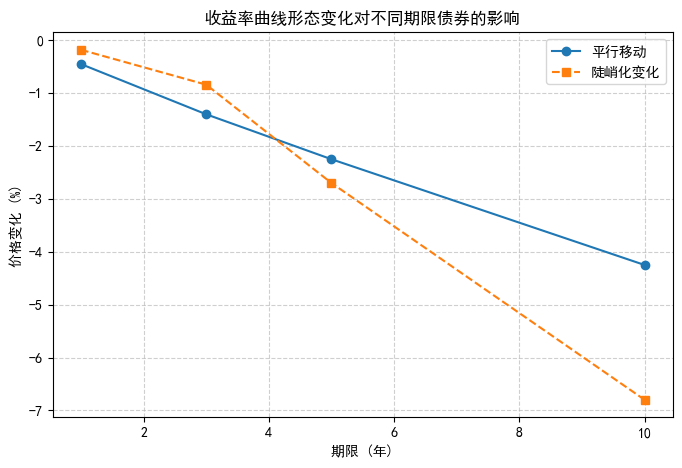

In [5]:
import pandas as pd
maturity = np.array([1, 3, 5, 10])
weights = np.array([0.3, 0.3, 0.2, 0.2])
duration = np.array([0.9, 2.8, 4.5, 8.5])
exposure = weights * duration
df = pd.DataFrame({'期限': maturity, '权重': weights, '久期': duration, '久期贡献': exposure})
display(df)
print(f'组合总久期 = {exposure.sum():.2f} 年')

# 模拟平行移动 vs 陡峭化
Δy_parallel = np.repeat(0.005, 4)
Δy_steep = np.array([0.002, 0.003, 0.006, 0.008])
ΔP_parallel = -duration * Δy_parallel
ΔP_steep = -duration * Δy_steep
plt.figure(figsize=(8,5))
plt.plot(maturity, ΔP_parallel*100, 'o-', label='平行移动')
plt.plot(maturity, ΔP_steep*100, 's--', label='陡峭化变化')
plt.title('收益率曲线形态变化对不同期限债券的影响')
plt.xlabel('期限 (年)')
plt.ylabel('价格变化 (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 模块 12. 课堂练习与扩展案例

### 练习 1：久期匹配
给定：
- 资产久期 5 年；
- 负债久期 8 年；
- 可投资短期债券久期 2 年、长期债券久期 10 年。
请计算各自投资权重以实现久期免疫。

### 练习 2：凸性调整
编写函数，计算债券价格变动的二阶近似：
$$ ΔP/P = -D_{mod} Δy + 0.5C(Δy)^2 $$
并验证在不同 Δy 下，久期与凸性联合估计的误差大小。

### 练习 3：AkShare 拓展
使用 AkShare 调用 `bond_zh_us_rate()` 数据，比较中国与美国国债收益率曲线差异。